In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import ase
import ase.io as aio
import qml
import time
import warnings
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from qml.kernels import gaussian_kernel
from qml.math import cho_solve
import copy
%config Completer.use_jedi = False
%matplotlib notebook

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
data = pd.read_csv('./reaction-representation/data.csv', index_col=0)

data.head()

,mol,Eafw,Earev,dErxn,ETS,ERt,EPr,enan,HRt,HPr,HTS,Hafw
0,1abp1,8.674063,17.793659,-9.119595,-1.453883e+06,-1.453892e+06,-1.453901e+06,R,-1.453681e+06,-1.453689e+06,-1.453672e+06,8.495217
1,1abp2,7.572784,19.457186,-11.884402,-1.453885e+06,-1.453892e+06,-1.453904e+06,R,-1.453681e+06,-1.453691e+06,-1.453673e+06,7.375741
2,1abp3,12.316128,22.034368,-9.718239,-1.453878e+06,-1.453891e+06,-1.453900e+06,R,-1.453679e+06,-1.453688e+06,-1.453667e+06,12.109041
3,1abp4,9.298435,22.482409,-13.183974,-1.453880e+06,-1.453889e+06,-1.453902e+06,R,-1.453678e+06,-1.453690e+06,-1.453669e+06,9.181712
4,1abp5,10.178204,22.937354,-12.759150,-1.453881e+06,-1.453892e+06,-1.453904e+06,R,-1.453680e+06,-1.453692e+06,-1.453670e+06,9.975511


In [76]:
data['ase_reactants'] = [aio.read(
    'data_react_xyz/' + data.mol.values[i] + data.enan.values[i] + '.xyz') for i in range(len(data))]

data['ase_products'] = [aio.read(
    'data_react_xyz/' + data.mol.values[i] + data.enan.values[i] + '.xyz') for i in range(len(data))]

mbtypes = np.load('./mbtypes.npy', allow_pickle=True)

data['SLATM_react'] = [qml.representations.generate_slatm(coordinates=mol.positions, 
                                                 nuclear_charges=mol.get_atomic_numbers(), 
                                                mbtypes=mbtypes, local=False) for mol in data['ase_reactants']]

data['SLATM_prod'] = [qml.representations.generate_slatm(coordinates=mol.positions, 
                                                 nuclear_charges=mol.get_atomic_numbers(), 
                                                mbtypes=mbtypes, local=False) for mol in data['ase_products']]

data[['Eafw', 'ERt', 'enan', 'ase_reactants', 'ase_products', 'SLATM_react', 'SLATM_prod']]

In [65]:
data['SLATM_diff'] = [x - y for x,y in zip(data.SLATM_prod.values, data.SLATM_react.values)]

In [66]:
Y = data.Eafw

In [67]:
slatm2 = np.vstack(data.SLATM_react.values)

In [68]:
slatmdiff = np.vstack(data.SLATM_diff.values)

We train 100 models using random 90/10 train/test splits. For each model we optimize the hyperparameter sigma and the optimal features for the case of SLATM_DIFFp

# Ensemble model SLATM_2

In [10]:
slatm2_dfs_test_preds = []
slatm2_dfs_test = []

model_curves = []
model_alphas = []

model_sigmas = []
model_rvalues = []

seeds = []

for i in range(100):
    print('Iteration: ', i)

    start_time = time.time()
    ratio = 0.1
    seed = i
    seeds.append(seed)
    indices_training, indices_test = train_test_split(np.arange(len(data)), test_size=ratio, random_state=seed)
    
    Xf = slatm2.copy()
    
    data_training = data.loc[indices_training]
    data_test = data.loc[indices_test]
    print('Training size: ', len(data_training))

    X_training = Xf[indices_training, :]
    X_test = Xf[indices_test, :]

    Y_training = data_training.Eafw.values
    ytmean = Y_training.mean()
    Y_training -= ytmean
    
    Y_test = data_test.Eafw.values

    dmtrtr = sk.metrics.pairwise.pairwise_distances(X_training, n_jobs=-1)
    dmtrts = sk.metrics.pairwise.pairwise_distances(X_test, X_training , n_jobs=-1)
    
    params = np.linspace(50,500,40)

    predictions_test_R = []
    scores_test_R = []

    predictions_train_R = []
    scores_train_R = []

    sigmas = []
    alphas_list = []
    regg = 1e-5
    
    for param in params:
        sigma=param
        K = np.exp(- 0.5 * sigma ** -2 * dmtrtr ** 2)
        K[np.diag_indices_from(K)] += regg
        alpha_vec = cho_solve(K, Y_training)

        # train predictions
        Y_predicted = np.dot(K, alpha_vec)    
        mae=np.mean(np.abs(Y_predicted - Y_training))
        scores_train_R.append(mae)
        predictions_train_R.append(Y_predicted)

        # test predictions
        Ks = np.exp(- 0.5 * sigma ** -2 * dmtrts ** 2)
        Y_predicted = np.dot(Ks, alpha_vec) + ytmean
        mae=np.mean(np.abs(Y_predicted - Y_test))
        scores_test_R.append(mae)
        predictions_test_R.append(Y_predicted)
    
        alphas_list.append(alpha_vec)
        sigmas.append(sigma)
    model_curves.append(scores_test_R)
    model_alphas.append(alphas_list)
    
    best_indx = np.argmin(scores_test_R)
    print('best:', best_indx)
    
    ypreds = []
    maes = []
    rmses = []
    
    Y_predicted_R = predictions_test_R[best_indx]
    
    mae=np.mean(np.abs(Y_predicted_R - Y_test))
    rmse = np.mean((Y_predicted_R - Y_test) ** 2)
    ypreds.append(Y_predicted_R)
    maes.append(mae)
    rmses.append(rmse)
    print('MAE KRR: ', mae, 'RMSE KRR: ', rmse)
        
    best = np.argmin(rmses)
    Y_predicted_R = ypreds[best]
    
    data_test['R_preds'] = Y_predicted_R
    data_training['R_preds'] = predictions_train_R[best_indx]
    
    slatm2_dfs_test.append(data_test.copy())
    print("--- %s seconds ---" % (time.time() - start_time))
    


Iteration:  0
Training size:  678
best: 6
MAE KRR:  0.547580671683371 RMSE KRR:  0.7784226743014633
--- 2.815788507461548 seconds ---
Iteration:  1
Training size:  678
best: 5
MAE KRR:  0.5943293984989247 RMSE KRR:  1.1878873722137497
--- 2.7337143421173096 seconds ---
Iteration:  2
Training size:  678
best: 8
MAE KRR:  0.5309502048919624 RMSE KRR:  0.6901436979344439
--- 2.7498960494995117 seconds ---
Iteration:  3
Training size:  678
best: 6
MAE KRR:  0.6196222494341029 RMSE KRR:  1.1264685539607031
--- 2.87072491645813 seconds ---
Iteration:  4
Training size:  678
best: 6
MAE KRR:  0.6227450428459033 RMSE KRR:  1.1309126158534484
--- 2.8204095363616943 seconds ---
Iteration:  5
Training size:  678
best: 2
MAE KRR:  0.5707380535064577 RMSE KRR:  1.1603459151877633
--- 2.8082754611968994 seconds ---
Iteration:  6
Training size:  678
best: 5
MAE KRR:  0.4054265291946281 RMSE KRR:  0.369667143947344
--- 2.7418181896209717 seconds ---
Iteration:  7
Training size:  678
best: 7
MAE KRR:  0

best: 5
MAE KRR:  0.5887760893362658 RMSE KRR:  1.3347683629093452
--- 2.7438623905181885 seconds ---
Iteration:  61
Training size:  678
best: 3
MAE KRR:  0.455029817043255 RMSE KRR:  0.5673342784154541
--- 2.7569923400878906 seconds ---
Iteration:  62
Training size:  678
best: 7
MAE KRR:  0.47941016421771876 RMSE KRR:  0.9312247819792239
--- 2.762639284133911 seconds ---
Iteration:  63
Training size:  678
best: 7
MAE KRR:  0.5381915646761113 RMSE KRR:  1.0458814133656489
--- 2.759127140045166 seconds ---
Iteration:  64
Training size:  678
best: 3
MAE KRR:  0.5441732624244228 RMSE KRR:  1.0901378789409772
--- 2.729990243911743 seconds ---
Iteration:  65
Training size:  678
best: 12
MAE KRR:  0.5838671078205704 RMSE KRR:  0.6455821104145568
--- 2.8127551078796387 seconds ---
Iteration:  66
Training size:  678
best: 8
MAE KRR:  0.5248510868114931 RMSE KRR:  0.8728901045737567
--- 2.7134830951690674 seconds ---
Iteration:  67
Training size:  678
best: 8
MAE KRR:  0.49291415175987896 RMSE 

In [11]:
slatm_2_df = pd.concat(slatm2_dfs_test)

In [12]:
slatm_2_df['ETS_pred'] = slatm_2_df.R_preds + slatm_2_df.ERt

slatm_2_dfRS = pd.merge(slatm_2_df[slatm_2_df.enan == 'R'], slatm_2_df[slatm_2_df.enan == 'S'], on='mol', suffixes=['R', 'S'])

slatm_2_dfRS['dETS'] = slatm_2_dfRS.ETSR - slatm_2_dfRS.ETSS
slatm_2_dfRS['dETS_pred'] = slatm_2_dfRS.ETS_predR - slatm_2_dfRS.ETS_predS

slatm_2_dde_preds_mean = - slatm_2_dfRS.groupby('mol').dETS_pred.mean()
slatm_2_dde_preds_std = - slatm_2_dfRS.groupby('mol').dETS_pred.std()



# Ensemble model SLATM_DIFF

In [13]:
slatmdiff_dfs_test_preds = []
slatmdiff_dfs_test = []

model_curves = []
model_alphas = []

model_sigmas = []
model_rvalues = []

seeds = []

for i in range(100):
    print('Iteration: ', i)

    start_time = time.time()
    ratio = 0.1

    seed = i
    seeds.append(seed)
    indices_training, indices_test = train_test_split(np.arange(len(data)), test_size=ratio, random_state=seed)
    
    Xf = slatmdiff.copy()
    
    data_training = data.loc[indices_training]
    data_test = data.loc[indices_test]
    print('Training size: ', len(data_training))
    ## diff

    X_training = Xf[indices_training, :]
    X_test = Xf[indices_test, :]

    Y_training = data_training.Eafw.values
    
    ytmean = Y_training.mean()
    
    Y_training -= ytmean
    
    Y_test = data_test.Eafw.values

    dmtrtr = sk.metrics.pairwise.pairwise_distances(X_training, n_jobs=-1)
    dmtrts = sk.metrics.pairwise.pairwise_distances(X_test, X_training , n_jobs=-1)
    
    params = np.linspace(0.1,20,40)

    predictions_test_R = []
    scores_test_R = []

    predictions_train_R = []
    scores_train_R = []

    sigmas = []
    alphas_list = []
    regg = 1e-6
    
    for param in params:
        sigma=param
        K = np.exp(- 0.5 * sigma ** -2 * dmtrtr ** 2)
        K[np.diag_indices_from(K)] += regg
        alpha_vec = cho_solve(K, Y_training)

        # train predictions
        Y_predicted = np.dot(K, alpha_vec)    
        mae=np.mean(np.abs(Y_predicted - Y_training))
        scores_train_R.append(mae)
        predictions_train_R.append(Y_predicted)

        # test predictions
        Ks = np.exp(- 0.5 * sigma ** -2 * dmtrts ** 2)
        Y_predicted = np.dot(Ks, alpha_vec) + ytmean
        mae=np.mean(np.abs(Y_predicted - Y_test))
        scores_test_R.append(mae)
        predictions_test_R.append(Y_predicted)
    
        alphas_list.append(alpha_vec)
        sigmas.append(sigma)
    model_curves.append(scores_test_R)
    model_alphas.append(alphas_list)
    
    best_indx = np.argmin(scores_test_R)
    print('best:', best_indx)
    
    ypreds = []
    maes = []
    rmses = []
    
    Y_predicted_R = predictions_test_R[best_indx]
    
    mae=np.mean(np.abs(Y_predicted_R - Y_test))
    rmse = np.mean((Y_predicted_R - Y_test) ** 2)
    ypreds.append(Y_predicted_R)
    maes.append(mae)
    rmses.append(rmse)
    print('MAE KRR: ', mae, 'RMSE KRR: ', rmse)
        
    best = np.argmin(rmses)
    Y_predicted_R = ypreds[best]
    
    data_test['R_preds'] = Y_predicted_R
    data_training['R_preds'] = predictions_train_R[best_indx]
    
    slatmdiff_dfs_test.append(data_test.copy())
    print("--- %s seconds ---" % (time.time() - start_time))
    


Iteration:  0
Training size:  678
best: 2
MAE KRR:  0.29096628443795736 RMSE KRR:  0.2897564772055095
--- 2.8165996074676514 seconds ---
Iteration:  1
Training size:  678
best: 3
MAE KRR:  0.2856021760413138 RMSE KRR:  0.2602650961828013
--- 2.818589210510254 seconds ---
Iteration:  2
Training size:  678
best: 3
MAE KRR:  0.29248453631585597 RMSE KRR:  0.5071877544301818
--- 2.815868377685547 seconds ---
Iteration:  3
Training size:  678
best: 3
MAE KRR:  0.30810523825820463 RMSE KRR:  0.583266973051001
--- 2.786177158355713 seconds ---
Iteration:  4
Training size:  678
best: 3
MAE KRR:  0.26195469029969437 RMSE KRR:  0.18217191512061817
--- 2.835822582244873 seconds ---
Iteration:  5
Training size:  678
best: 3
MAE KRR:  0.3019348792351965 RMSE KRR:  0.3211199163767028
--- 2.841543436050415 seconds ---
Iteration:  6
Training size:  678
best: 5
MAE KRR:  0.295430272947195 RMSE KRR:  0.21732923373434102
--- 2.843052625656128 seconds ---
Iteration:  7
Training size:  678
best: 4
MAE KRR:

best: 3
MAE KRR:  0.31622742953868527 RMSE KRR:  0.3179712731299087
--- 2.8296236991882324 seconds ---
Iteration:  61
Training size:  678
best: 2
MAE KRR:  0.25479070041438245 RMSE KRR:  0.13135226036223832
--- 2.856729030609131 seconds ---
Iteration:  62
Training size:  678
best: 3
MAE KRR:  0.2908495491827557 RMSE KRR:  0.513631638919838
--- 2.7988264560699463 seconds ---
Iteration:  63
Training size:  678
best: 2
MAE KRR:  0.39781059255628387 RMSE KRR:  0.7476504695331131
--- 2.7964694499969482 seconds ---
Iteration:  64
Training size:  678
best: 4
MAE KRR:  0.2921426129448384 RMSE KRR:  0.380578881354381
--- 2.8213956356048584 seconds ---
Iteration:  65
Training size:  678
best: 2
MAE KRR:  0.2914520434287295 RMSE KRR:  0.20481897194729684
--- 2.8224422931671143 seconds ---
Iteration:  66
Training size:  678
best: 2
MAE KRR:  0.23822464574513455 RMSE KRR:  0.13607370611810019
--- 2.7909045219421387 seconds ---
Iteration:  67
Training size:  678
best: 7
MAE KRR:  0.27016014733230076

In [14]:
slatm_diff_df = pd.concat(slatmdiff_dfs_test)

In [15]:
slatm_diff_df['ETS_pred'] = slatm_diff_df.R_preds + slatm_diff_df.ERt

slatm_diff_dfRS = pd.merge(slatm_diff_df[slatm_diff_df.enan == 'R'], slatm_diff_df[slatm_diff_df.enan == 'S'], on='mol', suffixes=['R', 'S'])

slatm_diff_dfRS['dETS'] = slatm_diff_dfRS.ETSR - slatm_diff_dfRS.ETSS
slatm_diff_dfRS['dETS_pred'] = slatm_diff_dfRS.ETS_predR - slatm_diff_dfRS.ETS_predS

slatm_diff_dde_preds_mean = - slatm_diff_dfRS.groupby('mol').dETS_pred.mean()
slatm_diff_dde_preds_std = - slatm_diff_dfRS.groupby('mol').dETS_pred.std()



# Ensemble model SLATM_DIFF+

In [17]:
slatmdiffp_dfs_test_preds = []
slatmdiffp_dfs_test = []

model_curves = []
model_alphas = []

model_sigmas = []
model_rvalues = []

seeds = []

for i in range(100):
    print('Iteration: ', i)

    start_time = time.time()
    ratio = 0.1

    seed=i
    seeds.append(seed)
    indices_training, indices_test = train_test_split(np.arange(len(data)), test_size=ratio, random_state=seed)

    lin_regs = [sp.stats.linregress(xs, ys) for xs, ys in zip(slatmdiff[indices_training].T, 
                                                         [Y[indices_training] for i in range(
                                                             slatmdiff.shape[1])])]   
    rvalues = np.array([ccc.rvalue for ccc in lin_regs])
    model_rvalues.append(rvalues)
    
    n_features = 500
    
    pre = sk.preprocessing.MinMaxScaler()
    pre.fit(slatmdiff[indices_training][:, np.argsort(rvalues**2)[-n_features:]])
    Xf =  pre.transform(slatmdiff[:, np.argsort(rvalues**2)[-n_features:]])
        
    data_training = data.loc[indices_training]
    data_test = data.loc[indices_test]
    print('Training size: ', len(data_training))
    ## diffp

    X_training = Xf[indices_training, :]
    X_test = Xf[indices_test, :]
   
    Y_training = data_training.Eafw.values
    
    ytmean = Y_training.mean()
    
    Y_training -= ytmean
    
    Y_test = data_test.Eafw.values

    dmtrtr = sk.metrics.pairwise.pairwise_distances(X_training, n_jobs=-1)
    dmtrts = sk.metrics.pairwise.pairwise_distances(X_test, X_training , n_jobs=-1)
    
    params = np.linspace(0.1,20,40)


    predictions_test_R = []
    scores_test_R = []

    predictions_train_R = []
    scores_train_R = []

    sigmas = []
    alphas_list = []
    regg = 1e-6
    
    for param in params:
        sigma=param
        K = np.exp(- 0.5 * sigma ** -2 * dmtrtr ** 2)
        K[np.diag_indices_from(K)] += regg
        alpha_vec = cho_solve(K, Y_training)

        # train predictions
        Y_predicted = np.dot(K, alpha_vec)    
        mae=np.mean(np.abs(Y_predicted - Y_training))
        scores_train_R.append(mae)
        predictions_train_R.append(Y_predicted)

        # test predictions
        Ks = np.exp(- 0.5 * sigma ** -2 * dmtrts ** 2)
        Y_predicted = np.dot(Ks, alpha_vec) + ytmean
        mae=np.mean(np.abs(Y_predicted - Y_test))
        scores_test_R.append(mae)
        predictions_test_R.append(Y_predicted)
    
        alphas_list.append(alpha_vec)
        sigmas.append(sigma)
    model_curves.append(scores_test_R)
    model_alphas.append(alphas_list)
    
    best_indx = np.argmin(scores_test_R)
    print('best:', best_indx)
    
    ypreds = []
    maes = []
    rmses = []
    
    Y_predicted_R = predictions_test_R[best_indx]
    
    mae=np.mean(np.abs(Y_predicted_R - Y_test))
    rmse = np.mean((Y_predicted_R - Y_test) ** 2)
    ypreds.append(Y_predicted_R)
    maes.append(mae)
    rmses.append(rmse)
    print('MAE KRR: ', mae, 'RMSE KRR: ', rmse)
        
    best = np.argmin(rmses)
    Y_predicted_R = ypreds[best]
    
    data_test['R_preds'] = Y_predicted_R
    data_training['R_preds'] = predictions_train_R[best_indx]
    
    slatmdiffp_dfs_test.append(data_test.copy())
    print("--- %s seconds ---" % (time.time() - start_time))
    


Iteration:  0
Training size:  678
best: 11
MAE KRR:  0.22411425529588228 RMSE KRR:  0.12293644793020382
--- 46.21560764312744 seconds ---
Iteration:  1
Training size:  678
best: 8
MAE KRR:  0.22089465294794844 RMSE KRR:  0.1455712390034723
--- 46.404977798461914 seconds ---
Iteration:  2
Training size:  678
best: 7
MAE KRR:  0.23074130519804226 RMSE KRR:  0.13843025324135058
--- 46.68587875366211 seconds ---
Iteration:  3
Training size:  678
best: 7
MAE KRR:  0.2502465783493295 RMSE KRR:  0.1961944146491986
--- 45.75314927101135 seconds ---
Iteration:  4
Training size:  678
best: 7
MAE KRR:  0.20479495671856124 RMSE KRR:  0.08758741856430918
--- 45.48370170593262 seconds ---
Iteration:  5
Training size:  678
best: 7
MAE KRR:  0.27340727134782167 RMSE KRR:  0.31255306452590126
--- 45.700881004333496 seconds ---
Iteration:  6
Training size:  678
best: 19
MAE KRR:  0.2412799079134592 RMSE KRR:  0.1510637981662332
--- 45.35026741027832 seconds ---
Iteration:  7
Training size:  678
best: 8


Training size:  678
best: 11
MAE KRR:  0.32931287209308147 RMSE KRR:  0.33458522284462033
--- 45.38884520530701 seconds ---
Iteration:  61
Training size:  678
best: 10
MAE KRR:  0.21866763287382743 RMSE KRR:  0.14012159034064886
--- 45.20635795593262 seconds ---
Iteration:  62
Training size:  678
best: 8
MAE KRR:  0.2135194928635393 RMSE KRR:  0.11630959955513114
--- 45.13915252685547 seconds ---
Iteration:  63
Training size:  678
best: 6
MAE KRR:  0.29904839168074765 RMSE KRR:  0.2665007611973735
--- 45.26104116439819 seconds ---
Iteration:  64
Training size:  678
best: 7
MAE KRR:  0.23578910512098944 RMSE KRR:  0.1612518966094143
--- 45.22163987159729 seconds ---
Iteration:  65
Training size:  678
best: 7
MAE KRR:  0.2233981213803572 RMSE KRR:  0.12917489566873677
--- 45.19243049621582 seconds ---
Iteration:  66
Training size:  678
best: 4
MAE KRR:  0.20931058000553016 RMSE KRR:  0.10870592828038843
--- 45.24036645889282 seconds ---
Iteration:  67
Training size:  678
best: 6
MAE KRR:

In [18]:
slatm_diffp_df = pd.concat(slatmdiffp_dfs_test)

In [19]:
slatm_diffp_df['ETS_pred'] = slatm_diffp_df.R_preds + slatm_diffp_df.ERt

slatm_diffp_dfRS = pd.merge(slatm_diffp_df[slatm_diffp_df.enan == 'R'], slatm_diffp_df[slatm_diffp_df.enan == 'S'], on='mol', suffixes=['R', 'S'])

slatm_diffp_dfRS['dETS'] = slatm_diffp_dfRS.ETSR - slatm_diffp_dfRS.ETSS
slatm_diffp_dfRS['dETS_pred'] = slatm_diffp_dfRS.ETS_predR - slatm_diffp_dfRS.ETS_predS

slatm_diffp_dde_preds_mean = - slatm_diffp_dfRS.groupby('mol').dETS_pred.mean()
slatm_diffp_dde_preds_std = - slatm_diffp_dfRS.groupby('mol').dETS_pred.std()



In [20]:
print('SLATM_DIFF+ MAE: :', np.mean(np.abs(slatm_diffp_df.R_preds - slatm_diffp_df.Eafw)))

SLATM_DIFF+ MAE: : 0.24833905999713737


# Predictions comparison

In [23]:
dfRS = slatm_diffp_dfRS

<IPython.core.display.Javascript object>


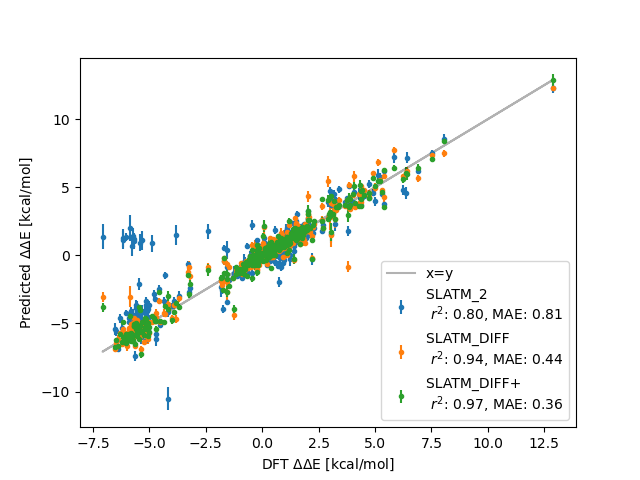

In [28]:
fig, ax = plt.subplots()

ax.errorbar(- dfRS.groupby('mol').dETS.mean(), slatm_2_dde_preds_mean, 
            slatm_2_dde_preds_std, linestyle='', marker='o', markersize=3, 
            label='SLATM_2 \n $r^2$: {:.2f}, MAE: {:.2f}'.format(
             np.corrcoef(slatm_2_df.R_preds, slatm_2_df.Eafw)[0,1] ** 2,
             np.mean(np.abs(- dfRS.groupby('mol').dETS.mean() - slatm_2_dde_preds_mean))   
            ))


ax.errorbar(- dfRS.groupby('mol').dETS.mean(), slatm_diff_dde_preds_mean, 
            slatm_diff_dde_preds_std, linestyle='', marker='o', markersize=3, 
            label='SLATM_DIFF \n $r^2$: {:.2f}, MAE: {:.2f}'.format(
             np.corrcoef(slatm_diff_df.R_preds, slatm_diff_df.Eafw)[0,1] ** 2,
             np.mean(np.abs(- dfRS.groupby('mol').dETS.mean() - slatm_diff_dde_preds_mean))   
            ))


ax.errorbar(- dfRS.groupby('mol').dETS.mean(), slatm_diffp_dde_preds_mean, 
            slatm_diffp_dde_preds_std, linestyle='', marker='o', markersize=3, 
            label='SLATM_DIFF+ \n $r^2$: {:.2f}, MAE: {:.2f}'.format(
            np.corrcoef(- dfRS.groupby('mol').dETS.mean(), slatm_diffp_dde_preds_mean)[0,1] ** 2,
             np.mean(np.abs(- dfRS.groupby('mol').dETS.mean() - slatm_diffp_dde_preds_mean))   
            ))

ax.plot(-dfRS.groupby('mol').dETS.mean(), -dfRS.groupby('mol').dETS.mean(), c='black', 
        alpha=0.3, label='x=y')


ax.set_xlabel('DFT $\Delta\Delta$E [kcal/mol]')

ax.set_ylabel('Predicted $\Delta\Delta$E [kcal/mol]')

ax.legend()

plt.show()